### Collaborative Filtering Using k-Nearest Neighbors (kNN)

kNN is a ML algo to find clusters of similar users based on common book ratings, and make predictions using the average raitng of top-k nearest neighbors.  For example, we first present ratings in a matrix, with the matrix having one row for each item (book), and one column for each user, like so:

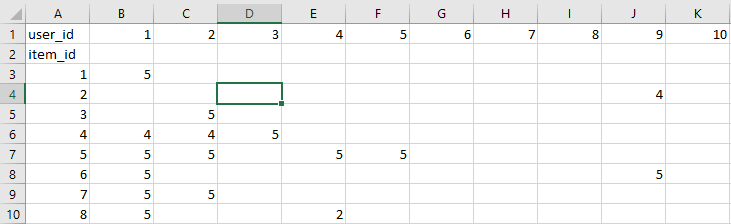

We then find the k item that have the most similar user engagement vectors.  Now let's implement kNN into our book recommender system.

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import sklearn
from sklearn.decomposition import TruncatedSVD

book = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding='latin-1')
book.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

user = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding='latin-1')
user.columns = ['userID', 'Location', 'Age']

rating = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding='latin-1')
rating.columns = ['userID', 'ISBN', 'bookRating']



b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/Users/sammylee/miniconda3/envs/DataScience/lib/python3.6/site-packages/IP

In [3]:
user.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
book.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
rating.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### To ensure statistical significance, we will only be looking at popular books

In order to find out which books are popular, we need to combine book data with rating data.



In [6]:
combine_book_rating = pd.merge(rating, book, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


### Filter to only popular books

Remove rows where book title is missing

In [7]:
combine_book_rating = combine_book_rating.dropna(axis=0, subset = ['bookTitle'])
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


In [8]:
combine_book_rating.shape

(1031136, 4)

In [17]:
book_ratingCount = (combine_book_rating.
                   groupby(by=['bookTitle'])['bookRating'].
                   count().
                   reset_index().
                   rename(columns = {'bookRating': 'totalRatingCount'})
                   [['bookTitle', 'totalRatingCount']]
                   )

book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [102]:
book_ratingCount.shape

(241071, 2)

#### Now we can merge the total rating count data into the rating data, giving us exactly what we need to filter out the lesser known books.

In [18]:
rating_with_totalRatingCount = pd.merge(combine_book_rating, book_ratingCount, left_on='bookTitle',
                                       right_on='bookTitle', how='left')

rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,276725,034545104X,0,Flesh Tones: A Novel,60
1,2313,034545104X,5,Flesh Tones: A Novel,60
2,6543,034545104X,0,Flesh Tones: A Novel,60
3,8680,034545104X,5,Flesh Tones: A Novel,60
4,10314,034545104X,9,Flesh Tones: A Novel,60


In [25]:
rating_with_totalRatingCount.shape

(1031136, 5)

In [103]:
# print(rating_with_totalRatingCount['totalRatingCount'].describe())

In [111]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

# I'm not sure why she uses the DataFrame 'book_ratingCount' here instead of 'rating_with_totalRatingCount'

count   241071.000
mean         4.277
std         16.739
min          1.000
25%          1.000
50%          1.000
75%          3.000
max       2502.000
Name: totalRatingCount, dtype: float64


#### The median book has only been rated one time.  Let's take a look at the top of the distribution.

In [106]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    7.000
0.910    8.000
0.920    9.000
0.930   10.000
0.940   11.000
0.950   13.000
0.960   16.000
0.970   20.000
0.980   29.000
0.990   50.000
Name: totalRatingCount, dtype: float64


#### So about 1% of books have 50 ratings, 2% have 29 ratings.  Since we have so many books in our data, we'll limit it to the top 1%, this will give us 2713 books.

In [109]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')

rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,276725,034545104X,0,Flesh Tones: A Novel,60
1,2313,034545104X,5,Flesh Tones: A Novel,60
2,6543,034545104X,0,Flesh Tones: A Novel,60
3,8680,034545104X,5,Flesh Tones: A Novel,60
4,10314,034545104X,9,Flesh Tones: A Novel,60


In [110]:
rating_popular_book.shape

(288740, 5)

#### Filtering to US users only

In [51]:
combined = rating_popular_book.merge(user, left_on = 'userID', right_on = 'userID', how = 'left')

us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating = us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,276725,034545104X,0,Flesh Tones: A Novel,60,"tyler, texas, usa"
1,2313,034545104X,5,Flesh Tones: A Novel,60,"cincinnati, ohio, usa"
2,6543,034545104X,0,Flesh Tones: A Novel,60,"strafford, missouri, usa"
3,8680,034545104X,5,Flesh Tones: A Novel,60,"st. charles county, missouri, usa"
4,10314,034545104X,9,Flesh Tones: A Novel,60,"beaverton, oregon, usa"


In [52]:
us_canada_user_rating.shape

(251615, 6)

In [53]:
if not us_canada_user_rating[us_canada_user_rating.duplicated(['userID', 'bookTitle'])].empty:
    initial_rows = us_canada_user_rating.shape[0]
    
    print('Initial dataframe shape {0}'.format(us_canada_user_rating.shape))
    us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
    current_rows = us_canada_user_rating.shape[0]
    print('New dataframe shape {0}'.format(us_canada_user_rating.shape))
    print('Removed {0} rows'.format(initial_rows - current_rows))


Initial dataframe shape (251615, 6)
New dataframe shape (248949, 6)
Removed 2666 rows


In [47]:
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
us_canada_user_rating.shape

(248949, 6)

In [54]:
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID',
                                                         values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

In [100]:
us_canada_user_rating_pivot.shape

(2442, 40017)

In [55]:
us_canada_user_rating_pivot.head()

userID,8,9,14,16,17,23,26,32,39,42,...,278820,278824,278828,278832,278836,278843,278844,278846,278851,278854
bookTitle,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
16 Lighthouse Road,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1984,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1st to Die: A Novel,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2010: Odyssey Two,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [63]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

### Test our model and make some recommendations:

In this step, the kNN algorithm measures distance to determine the "closeness" of instances.  It then classifies an instance by finding its nearest neighbors, and picks the most popular class among the neighbors.

In [74]:
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Daisy Fay and the Miracle Man:

1: Fried Green Tomatoes at the Whistle Stop Cafe, with distance of 0.873373941100811:
2: The Stone Diaries, with distance of 0.8766136287164453:
3: Burn Marks (V.I. Warshawski Novels (Paperback)), with distance of 0.8775451218798536:
4: Moo, with distance of 0.9004036083767288:
5: Welcome to the World, Baby Girl!, with distance of 0.9026996660477862:


In [82]:
us_canada_user_rating_pivot2 = us_canada_user_rating.pivot(index = 'userID', columns = 'bookTitle',
                                                          values = 'bookRating').fillna(0)

In [83]:
us_canada_user_rating_pivot2.head()

bookTitle,10 Lb. Penalty,16 Lighthouse Road,1984,1st to Die: A Novel,2010: Odyssey Two,204 Rosewood Lane,2061: Odyssey Three,24 Hours,2nd Chance,3rd Degree,...,YOU BELONG TO ME,Year of Wonders,You Belong To Me,You Shall Know Our Velocity,Young Wives,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw""","\Surely You're Joking, Mr. Feynman!\"": Adventures of a Curious Character""",stardust
userID,,,,,,,,,,,,,,,,,,,,,
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
14,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
17,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [84]:
us_canada_user_rating_pivot2.shape

(40017, 2442)

In [85]:
X = us_canada_user_rating_pivot2.values.T
X.shape

(2442, 40017)

In [86]:
SVD = TruncatedSVD(n_components=12, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

(2442, 12)

In [88]:
import warnings
warnings.filterwarnings("ignore", category = RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape

(2442, 2442)

In [94]:
us_canada_book_title = us_canada_user_rating_pivot2.columns
us_canada_book_list = list(us_canada_book_title)
coffey_hands = us_canada_book_list.index("1984")
print(coffey_hands)

2


In [95]:
corr_coffey_hands = corr[coffey_hands]

In [96]:
list(us_canada_book_title[(corr_coffey_hands<1.0) & (corr_coffey_hands>0.9)])

['A Clockwork Orange (Norton Paperback Fiction)',
 'A Portrait of the Artist As a Young Man',
 'Animal Farm',
 'Atlas Shrugged',
 'Bless Me, Ultima',
 'Brave New World',
 'Breakfast of Champions',
 "Cat's Cradle",
 'Catch 22',
 'Dandelion Wine (Grand Master Editions)',
 'Death of A Salesman',
 'Dune (Remembering Tomorrow)',
 "Ender's Game (Ender Wiggins Saga (Paperback))",
 'Flowers for Algernon (Bantam Classic)',
 "Foucault's Pendulum",
 'Frankenstein',
 'Free',
 'Good Omens',
 'Grendel',
 'Hocus Pocus',
 'I Never Promised You a Rose Garden',
 'I, Robot',
 'Lion, the Witch and the Wardrobe',
 'Lord of the Flies',
 'Neverwhere',
 'Nine Stories',
 "One Flew Over the Cuckoo's Nest",
 'Rendezvous with Rama',
 'Sense and Sensibility',
 "Slaughterhouse Five or the Children's Crusade: A Duty Dance With Death",
 'Something Wicked This Way Comes',
 'Soul Mountain',
 'Stranger in a Strange Land (Remembering Tomorrow)',
 'The Chosen',
 'The Color Purple',
 'The Crucible: A Play in Four Acts (Pen